<a href="https://colab.research.google.com/github/mr-nastik/new_test_sub/blob/master/final_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
PATH='/content/drive/My Drive/bengaliai-cv19/'
HEIGHT = 137
WIDTH = 236
SIZE = 128
batch_size = 256
epochs = 32

# **modules which we need**

In [3]:

#module for model

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

#for data handaling
from tqdm.auto import tqdm
import numpy as np
import pandas as pd 

#for image processing
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

#for calc accuaracy and spliting the data
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Function for Cropping and resiing the given image data to own**

In [0]:
def crop_resize_image(image_df):
    cropped_resized_img={}
    for i in tqdm(range(len(image_df))):
        image=image_df.iloc[i].values.reshape(HEIGHT,WIDTH)
        _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)[-2:]
        x_min=[]
        x_max=[]
        y_min=[]
        y_max=[]
        for cordinate in contours:
            x,y,w,h=cv2.boundingRect(cordinate)
            x_min.append(x)
            x_max.append(x+w)
            y_min.append(y)
            y_max.append(y+h)
        x1=min(x_min)
        x2=max(x_max)
        y1=min(y_min)
        y2=max(y_max)
        cropped_img=image[y1:y2,x1:x2]
        resized_img=cv2.resize(cropped_img,(SIZE,SIZE),interpolation=cv2.INTER_AREA)
        cropped_resized_img[i]=resized_img.reshape(-1)
    return pd.DataFrame(cropped_resized_img).T

# **visualizing the train.csv data**

In [5]:
df=pd.read_csv(PATH+'input/train.csv')
print(df.head())
print(df.tail())
print("shape of train.csv: ",df.shape)

  image_id  grapheme_root  vowel_diacritic  consonant_diacritic grapheme
0  Train_0             15                9                    5   ক্ট্রো
1  Train_1            159                0                    0        হ
2  Train_2             22                3                    5     খ্রী
3  Train_3             53                2                    2     র্টি
4  Train_4             71                9                    5     থ্রো
            image_id  grapheme_root  ...  consonant_diacritic  grapheme
200835  Train_200835             22  ...                    2      র্খে
200836  Train_200836             65  ...                    0      ত্তো
200837  Train_200837              2  ...                    4      অ্যা
200838  Train_200838            152  ...                    0      স্নো
200839  Train_200839            127  ...                    0      ল্টি

[5 rows x 5 columns]
shape of train.csv:  (200840, 5)


In [0]:
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes of selected feature; feature is a categorical value
    param: feature - the feature for which we present the distribution of classes
    param: title - title to show in the plot
    param: df - dataframe 
    param: size - size (from 1 to n), multiplied with 4 - size of plot
    '''
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(df[feature], order = df[feature].value_counts().index[:30], palette='Set3')
    g.set_title("Number and percentage of {}".format(title))
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.savefig('freq of '+feature+'.png', dpi=300, bbox_inches='tight')
    plt.show() 

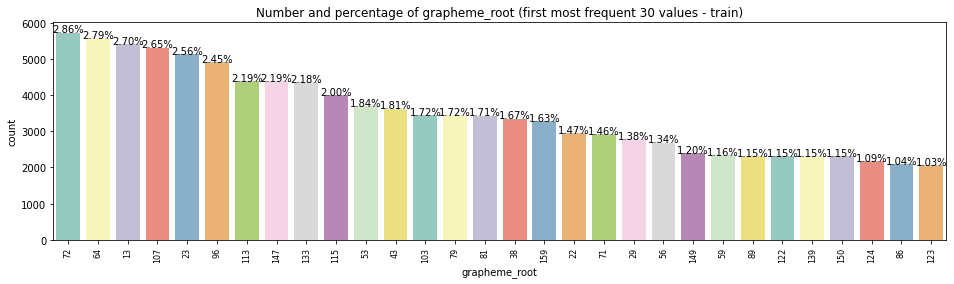

In [7]:
plot_count('grapheme_root', 'grapheme_root (first most frequent 30 values - train)', df, size=4)

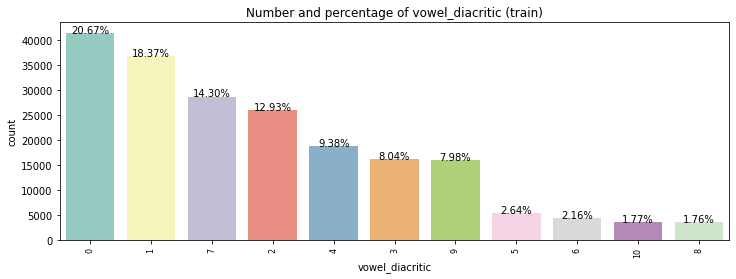

In [8]:
plot_count('vowel_diacritic', 'vowel_diacritic (train)', df, size=3)

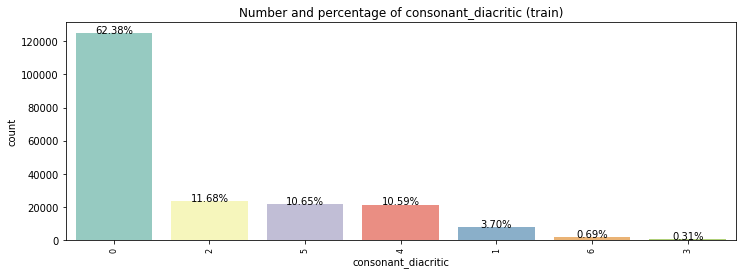

In [9]:
plot_count('consonant_diacritic', 'consonant_diacritic (train)', df, size=3)

# **visualizing the test.csv data**

In [10]:
df=pd.read_csv(PATH+'input/test.csv')
print(df.head())
print(df.tail())
print("shape of train.csv: ",df.shape)

                       row_id image_id            component
0  Test_0_consonant_diacritic   Test_0  consonant_diacritic
1        Test_0_grapheme_root   Test_0        grapheme_root
2      Test_0_vowel_diacritic   Test_0      vowel_diacritic
3  Test_1_consonant_diacritic   Test_1  consonant_diacritic
4        Test_1_grapheme_root   Test_1        grapheme_root
                         row_id image_id            component
31        Test_10_grapheme_root  Test_10        grapheme_root
32      Test_10_vowel_diacritic  Test_10      vowel_diacritic
33  Test_11_consonant_diacritic  Test_11  consonant_diacritic
34        Test_11_grapheme_root  Test_11        grapheme_root
35      Test_11_vowel_diacritic  Test_11      vowel_diacritic
shape of train.csv:  (36, 3)


# **visualizing the train image data parquet file**

In [11]:
df=pd.read_parquet(PATH+'input/train_image_data_3.parquet')
print(df.head())
print(df.tail())
print("shape of train_image_data_3.parquet: ",df.shape)

       image_id    0    1    2    3  ...  32327  32328  32329  32330  32331
0  Train_150630  246  245  244  244  ...    251    251    252    253    252
1  Train_150631  213  241  247  247  ...    196    194    192    175    117
2  Train_150632  253  253  252  252  ...    253    253    253    253    253
3  Train_150633  252  252  252  252  ...    255    255    255    255    255
4  Train_150634  255  255  255  255  ...    255    255    255    255    255

[5 rows x 32333 columns]
           image_id    0    1    2    3  ...  32327  32328  32329  32330  32331
50205  Train_200835  236  233  237  233  ...    255    255    255    255    255
50206  Train_200836  250  250  252  252  ...    253    253    254    254    253
50207  Train_200837  255  255  255  255  ...    253    253    253    253    253
50208  Train_200838  246  246  244  242  ...    250    253    252    251    252
50209  Train_200839  211  243  250  250  ...    205    203    202    165     86

[5 rows x 32333 columns]
shape of tra

 **Visualizing the training set image**

[[213. 241. 247. ... 248. 230. 144.]
 [220. 247. 249. ... 249. 223. 145.]
 [215. 246. 249. ... 247. 220. 139.]
 ...
 [225. 245. 249. ... 239. 209. 126.]
 [221. 242. 245. ... 238. 211. 131.]
 [185. 205. 208. ... 192. 175. 117.]]
shape of real img:  (137, 236)


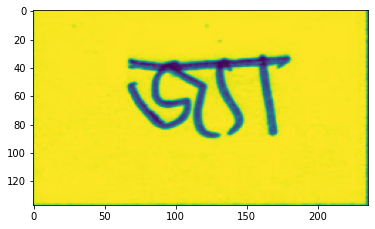

In [12]:
df=df.drop(columns='image_id')
img=df.iloc[1].values.reshape(137,236).astype(float)
print(img)
print("shape of real img: ",img.shape)
plt.imshow(img)

 **visualizing the cropped and resized image**


[[247. 246. 245. ... 248. 239. 165.]
 [252. 252. 251. ... 251. 235. 163.]
 [253. 253. 253. ... 250. 235. 159.]
 ...
 [252. 250. 250. ... 246. 226. 150.]
 [249. 249. 249. ... 242. 224. 150.]
 [214. 212. 209. ... 197. 186. 132.]]
shape of cropped image:  (128, 128)


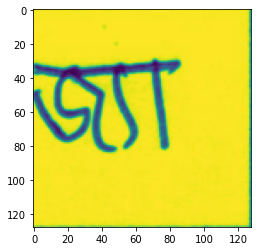

In [13]:
df=crop_resize_image(df)
img=df.iloc[1].values.reshape(128,128).astype(float)
print(img)
print("shape of cropped image: ",img.shape)
plt.imshow(img)

# **visualizing the train image data parquet file**

In [14]:
df=pd.read_parquet(PATH+'input/test_image_data_3.parquet')
print(df.head())
print(df.tail())
print("shape of test_image_data_3.parquet: ",df.shape)

  image_id    0    1    2    3    4  ...  32326  32327  32328  32329  32330  32331
0   Test_9  250  251  249  248  248  ...    252    253    254    253    253    253
1  Test_10  245  246  248  249  250  ...    254    254    254    254    254    254
2  Test_11  252  252  252  252  252  ...    253    253    253    253    253    252

[3 rows x 32333 columns]
  image_id    0    1    2    3    4  ...  32326  32327  32328  32329  32330  32331
0   Test_9  250  251  249  248  248  ...    252    253    254    253    253    253
1  Test_10  245  246  248  249  250  ...    254    254    254    254    254    254
2  Test_11  252  252  252  252  252  ...    253    253    253    253    253    252

[3 rows x 32333 columns]
shape of test_image_data_3.parquet:  (3, 32333)


 **visualizing the test image**

[[245. 246. 248. ... 247. 245. 247.]
 [251. 251. 250. ... 250. 249. 252.]
 [250. 251. 251. ... 251. 251. 253.]
 ...
 [253. 255. 255. ... 255. 255. 255.]
 [252. 254. 254. ... 255. 255. 255.]
 [250. 253. 253. ... 254. 254. 254.]]
shape of real img:  (137, 236)


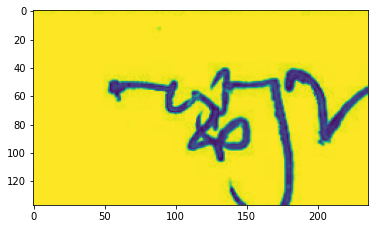

In [15]:
df=df.drop(columns='image_id')
img=df.iloc[1].values.reshape(137,236).astype(float)
print(img)
print("shape of real img: ",img.shape)
plt.imshow(img)

 **visualizing the test cropped and resized image**


[[254. 254. 254. ... 253. 253. 253.]
 [253. 254. 254. ... 253. 253. 253.]
 [253. 254. 254. ... 253. 253. 253.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [254. 254. 254. ... 254. 254. 254.]
 [254. 254. 254. ... 254. 254. 254.]]
shape of cropped image:  (128, 128)


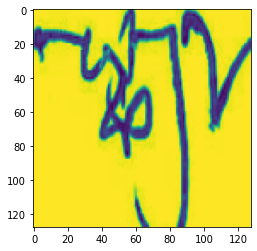

In [16]:
df=crop_resize_image(df)
img=df.iloc[1].values.reshape(128,128).astype(float)
print(img)
print("shape of cropped image: ",img.shape)
plt.imshow(img)

# **visualizing the sample submission file**

In [17]:
df=pd.read_csv(PATH+'input/sample_submission.csv')
print(df.head())
print(df.tail())
print("shape of train.csv: ",df.shape)

                       row_id  target
0  Test_0_consonant_diacritic       0
1        Test_0_grapheme_root       0
2      Test_0_vowel_diacritic       0
3  Test_1_consonant_diacritic       0
4        Test_1_grapheme_root       0
                         row_id  target
31        Test_10_grapheme_root       0
32      Test_10_vowel_diacritic       0
33  Test_11_consonant_diacritic       0
34        Test_11_grapheme_root       0
35      Test_11_vowel_diacritic       0
shape of train.csv:  (36, 2)


# **Simple CNN Model using keras**

In [0]:
inputs= Input(shape=(SIZE,SIZE,1))
model=Conv2D(filters=32,kernel_size=(5,5),padding='SAME',activation='relu',input_shape=(SIZE,SIZE,1))(inputs)
model=BatchNormalization(momentum=0.2)(model)
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=32,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=64,kernel_size=(3,3),padding='SAME',activation='relu')(model)

model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=BatchNormalization(momentum=0.2)(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Conv2D(filters=128,kernel_size=(3,3),padding='SAME',activation='relu')(model)
model=MaxPool2D(pool_size=(2,2))(model)

model=Flatten()(model)
model=Dense(1024,activation='relu')(model)
model=BatchNormalization(momentum=0.2)(model)
model=Dense(512,activation='relu')(model)
model=BatchNormalization(momentum=0.2)(model)

root=Dense(168,activation='softmax',name='root')(model)
vowel=Dense(11,activation='softmax',name='vowel')(model)
consonant=Dense(7,activation='softmax',name='consonant')(model)

model=Model(inputs=inputs,outputs=[root,vowel,consonant])

In [19]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 832         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        batch_normalization_1[0][0]      
____________________________________________________________________________________________

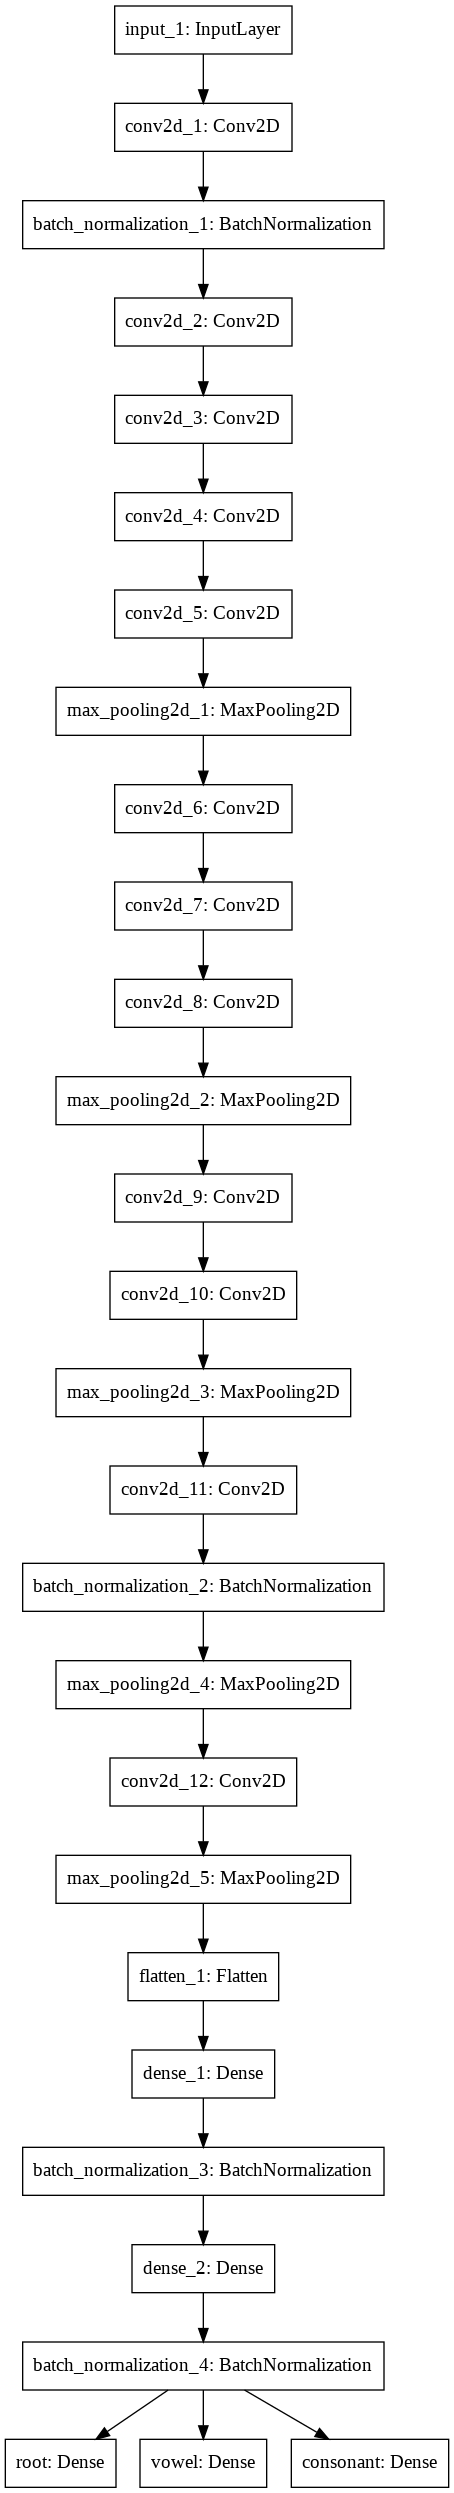

In [20]:
from keras.utils import plot_model
plot_model(model, to_file=PATH+'model_visual.png')

**Setting up the reduce learning rate to increase accuracy**

In [0]:
lr_root=ReduceLROnPlateau(monitor='root_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)
lr_vowel=ReduceLROnPlateau(monitor='vowel_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)
lr_consonant=ReduceLROnPlateau(monitor='consonant_acc',factor=0.9,patience=3,min_lr=0.00001,verbose=1)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


[multiclassoutputgenerator class](https://github.com/keras-team/keras/issues/12639#issuecomment-506338552) for multioutput by a single model

In [0]:
class MultiOutputDataGenerator(keras.preprocessing.image.ImageDataGenerator):

    def flow(self,
             x,
             y=None,
             batch_size=batch_size,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):

        targets = None
        target_lengths = {}
        ordered_outputs = []
        for output, target in y.items():
            if targets is None:
                targets = target
            else:
                targets = np.concatenate((targets, target), axis=1)
            target_lengths[output] = target.shape[1]
            ordered_outputs.append(output)


        for flowx, flowy in super().flow(x, targets, batch_size=batch_size,shuffle=shuffle):
            target_dict = {}
            i = 0
            for output in ordered_outputs:
                target_length = target_lengths[output]
                target_dict[output] = flowy[:, i: i + target_length]
                i += target_length

            yield flowx, target_dict

In [0]:
def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

# **Training**

In [25]:
train_image_info=pd.read_csv(PATH+'input/train.csv')

records={}

for i in range(3):
    train_image=pd.read_parquet(PATH+'input/train_image_data_'+str(i)+'.parquet').drop(['image_id'],axis=1)
    
    Y_train=train_image_info[i*50210:(i+1)*50210]
    X_train=crop_resize_image(train_image).values.reshape(-1,SIZE,SIZE,1)
    #plt.imshow(train_image.iloc[100].values.reshape(HEIGHT,WIDTH))
    del train_image

    #plt.imshow(X_train[100])
    #print(Y_train.iloc[100])
    #print('splitting about to start')

    x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=13)
    del X_train
    del Y_train
    #print('splitting completed')

    data_generator=MultiOutputDataGenerator()
    data_generator.fit(x_train)
    #print('fitting completed')

    y_train_root = pd.get_dummies(y_train['grapheme_root']).values
    y_train_vowel = pd.get_dummies(y_train['vowel_diacritic']).values
    y_train_consonant = pd.get_dummies(y_train['consonant_diacritic']).values
    
    y_test_root = pd.get_dummies(y_test['grapheme_root']).values
    y_test_vowel = pd.get_dummies(y_test['vowel_diacritic']).values
    y_test_consonant = pd.get_dummies(y_test['consonant_diacritic']).values

    del y_train
    del y_test

    #print('learning about to start')
    result=model.fit_generator(
        data_generator.flow(
            x_train,
            {
                'root':y_train_root,'vowel':y_train_vowel,'consonant':y_train_consonant
            },
            batch_size=batch_size
        ),
        epochs=epochs,
        validation_data=(x_test,[y_test_root,y_test_vowel,y_test_consonant]),
        steps_per_epoch=y_train_root.shape[0]//batch_size,
        callbacks=[lr_root,lr_vowel,lr_consonant]
    )
    del x_train
    del x_test
    del y_train_root
    del y_train_vowel
    del y_train_consonant
    del y_test_root
    del y_test_vowel
    del y_test_consonant

    records=appendHist(records,result.history) 


Epoch 1/32
156/156 [==============================] - 258s 2s/step - loss: 5.7130 - root_loss: 3.9777 - vowel_loss: 0.8682 - consonant_loss: 0.8671 - root_accuracy: 0.1554 - vowel_accuracy: 0.7199 - consonant_accuracy: 0.7340 - val_loss: 3.6925 - val_root_loss: 2.7069 - val_vowel_loss: 0.5287 - val_consonant_loss: 0.4511 - val_root_accuracy: 0.3163 - val_vowel_accuracy: 0.8243 - val_consonant_accuracy: 0.8513
Epoch 2/32


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `root_acc` which is not available. Available metrics are: val_loss,val_root_loss,val_vowel_loss,val_consonant_loss,val_root_accuracy,val_vowel_accuracy,val_consonant_accuracy,loss,root_loss,vowel_loss,consonant_loss,root_accuracy,vowel_accuracy,consonant_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `vowel_acc` which is not available. Available metrics are: val_loss,val_root_loss,val_vowel_loss,val_consonant_loss,val_root_accuracy,val_vowel_accuracy,val_consonant_accuracy,loss,root_loss,vowel_loss,consonant_loss,root_accuracy,vowel_accuracy,consonant_accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:1042: R

156/156 [==============================] - 254s 2s/step - loss: 2.4865 - root_loss: 1.7963 - vowel_loss: 0.3578 - consonant_loss: 0.3325 - root_accuracy: 0.5285 - vowel_accuracy: 0.8836 - consonant_accuracy: 0.8913 - val_loss: 2.2136 - val_root_loss: 1.5642 - val_vowel_loss: 0.3416 - val_consonant_loss: 0.3074 - val_root_accuracy: 0.5772 - val_vowel_accuracy: 0.8888 - val_consonant_accuracy: 0.8944
Epoch 3/32
156/156 [==============================] - 250s 2s/step - loss: 1.4091 - root_loss: 0.9648 - vowel_loss: 0.2286 - consonant_loss: 0.2156 - root_accuracy: 0.7354 - vowel_accuracy: 0.9273 - consonant_accuracy: 0.9275 - val_loss: 1.5279 - val_root_loss: 1.0470 - val_vowel_loss: 0.2487 - val_consonant_loss: 0.2295 - val_root_accuracy: 0.7029 - val_vowel_accuracy: 0.9192 - val_consonant_accuracy: 0.9240
Epoch 4/32
156/156 [==============================] - 249s 2s/step - loss: 0.8972 - root_loss: 0.5959 - vowel_loss: 0.1553 - consonant_loss: 0.1461 - root_accuracy: 0.8366 - vowel_accur


Epoch 1/32
156/156 [==============================] - 249s 2s/step - loss: 2.2204 - root_loss: 1.4598 - vowel_loss: 0.4035 - consonant_loss: 0.3570 - root_accuracy: 0.6305 - vowel_accuracy: 0.8831 - consonant_accuracy: 0.8974 - val_loss: 1.2803 - val_root_loss: 0.8548 - val_vowel_loss: 0.2303 - val_consonant_loss: 0.1974 - val_root_accuracy: 0.7517 - val_vowel_accuracy: 0.9251 - val_consonant_accuracy: 0.9374
Epoch 2/32
156/156 [==============================] - 248s 2s/step - loss: 0.7778 - root_loss: 0.4979 - vowel_loss: 0.1421 - consonant_loss: 0.1377 - root_accuracy: 0.8509 - vowel_accuracy: 0.9548 - consonant_accuracy: 0.9559 - val_loss: 1.0765 - val_root_loss: 0.7165 - val_vowel_loss: 0.1979 - val_consonant_loss: 0.1661 - val_root_accuracy: 0.7998 - val_vowel_accuracy: 0.9380 - val_consonant_accuracy: 0.9472
Epoch 3/32
156/156 [==============================] - 247s 2s/step - loss: 0.4162 - root_loss: 0.2535 - vowel_loss: 0.0816 - consonant_loss: 0.0810 - root_accuracy: 0.9258 -


Epoch 1/32
156/156 [==============================] - 248s 2s/step - loss: 1.7485 - root_loss: 1.1512 - vowel_loss: 0.3202 - consonant_loss: 0.2771 - root_accuracy: 0.7139 - vowel_accuracy: 0.9100 - consonant_accuracy: 0.9227 - val_loss: 1.1647 - val_root_loss: 0.7474 - val_vowel_loss: 0.2112 - val_consonant_loss: 0.2090 - val_root_accuracy: 0.7952 - val_vowel_accuracy: 0.9431 - val_consonant_accuracy: 0.9384
Epoch 2/32
156/156 [==============================] - 248s 2s/step - loss: 0.5534 - root_loss: 0.3519 - vowel_loss: 0.1025 - consonant_loss: 0.0989 - root_accuracy: 0.8915 - vowel_accuracy: 0.9681 - consonant_accuracy: 0.9673 - val_loss: 0.9966 - val_root_loss: 0.6215 - val_vowel_loss: 0.1816 - val_consonant_loss: 0.1907 - val_root_accuracy: 0.8300 - val_vowel_accuracy: 0.9493 - val_consonant_accuracy: 0.9472
Epoch 3/32
156/156 [==============================] - 248s 2s/step - loss: 0.2633 - root_loss: 0.1600 - vowel_loss: 0.0509 - consonant_loss: 0.0524 - root_accuracy: 0.9529 -

In [26]:
print(records)

{'val_loss': [3.6924587054880367, 2.213628594368678, 1.527933428710591, 1.3983732004418266, 1.2728882020651355, 1.2493027337540956, 1.227435151981277, 1.2259996068878873, 1.1765023504825873, 1.1479290040620553, 1.1452581673071123, 1.1654984902347898, 1.1641220799054646, 1.1724256473669277, 1.183504460817598, 1.1904786722139162, 1.2121094431541897, 1.2037598319415481, 1.2186577094311117, 1.2400092026361595, 1.2434154970905644, 1.2630501870637965, 1.25055456360933, 1.2601004343682423, 1.2653183552924914, 1.2810269740206672, 1.272584980736926, 1.3042944885539571, 1.2908466186116971, 1.3288427185333243, 1.3302277057585405, 1.3245243643698192, 1.2802977062416039, 1.0765292356745984, 1.021042020001323, 1.0124826125475639, 1.0167204829901486, 1.0200718320524804, 1.0195507833003712, 1.0485939057883311, 1.037489837110102, 1.0545817707620562, 1.0963626183069362, 1.1252924369592825, 1.104313207133266, 1.1063640604121732, 1.1296414232092582, 1.1225024745227379, 1.147010421733936, 1.174547723673463

# **ploting graphs**

In [0]:
def plot_graph(x,s='loss'):
    fig= plt.figure(figsize=(10,10))
    plt.plot(x['val_root_'+s])
    plt.plot(x['val_vowel_'+s])
    plt.plot(x['val_consonant_'+s])
    plt.plot(x['root_'+s])
    plt.plot(x['vowel_'+s])
    plt.plot(x['consonant_'+s])
    plt.title('Learning Dataset '+s)
    plt.ylabel(s)
    plt.xlabel('epoch')
    if s=='accuracy':
        plt.legend(['val_root_'+s,'val_vowel_'+s,'val_consonant_'+s,'root_'+s,'vowel_'+s,'consonant_'+s], loc='best')
    else:
        plt.plot(x['val_'+s])
        plt.plot(x[s])
        plt.legend(['val_root_'+s,'val_vowel_'+s,'val_consonant_'+s,'root_'+s,'vowel_'+s,'consonant_'+s,'val_'+s,s], loc='best')
    plt.savefig(s+'.png', dpi=300, bbox_inches='tight')
    plt.show()

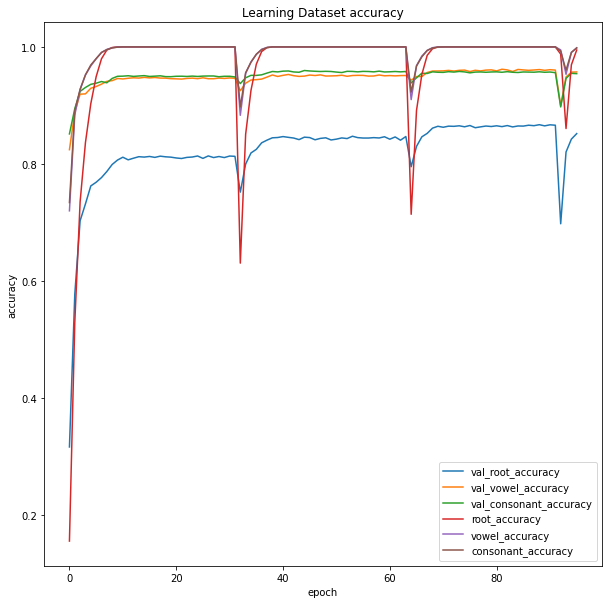

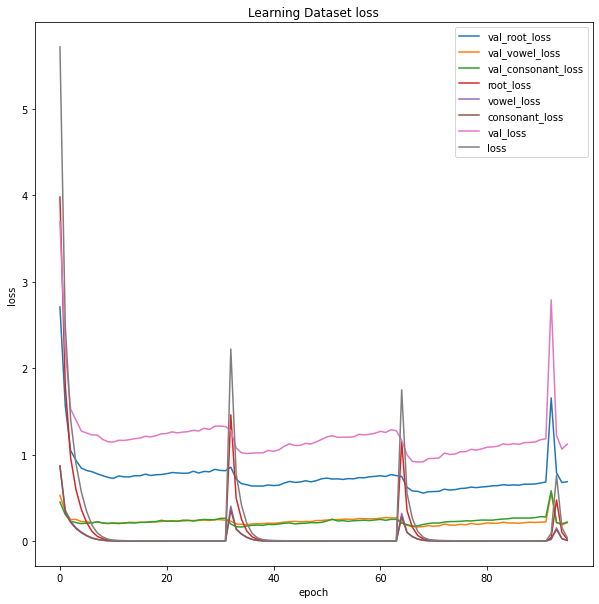

In [28]:
plot_graph(records,'accuracy')
plot_graph(records,'loss')

# **testing**

In [0]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}

In [0]:
temp = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
preds_dict = {}
preds_dict['grapheme_root']=[]
preds_dict['consonant_diacritic']=[]
preds_dict['vowel_diacritic']=[]

In [38]:
y_test=pd.read_csv(PATH+'input/train.csv')
y_test=y_test[3*50210:]
#print(y_test)
for i in range(3,4):
    test_image=pd.read_parquet(PATH+'input/train_image_data_'+str(i)+'.parquet')
    test_image.set_index('image_id',inplace=True)
    x_test=crop_resize_image(test_image).values.reshape(-1,SIZE,SIZE,1)
    preds = model.predict(x_test)
    for j, p in enumerate(temp):
        temp[p] = np.argmax(preds[j], axis=1)
    preds_dict['grapheme_root'].extend(temp['grapheme_root'])
    preds_dict['vowel_diacritic'].extend(temp['vowel_diacritic'])
    preds_dict['consonant_diacritic'].extend(temp['consonant_diacritic'])
    #print(len(preds_dict['grapheme_root']))

**testing score**

In [39]:
root_acc=accuracy_score(y_test['grapheme_root'].values.astype(float),preds_dict['grapheme_root'])
vowel_acc=accuracy_score(y_test['vowel_diacritic'].values.astype(float),preds_dict['vowel_diacritic'])
consonant_acc=accuracy_score(y_test['consonant_diacritic'].values.astype(float),preds_dict['consonant_diacritic'])
print('Grapheme Roots accuracy: ',root_acc)
print('Vowel Diacritic accuracy: ',vowel_acc)
print('consonant Diacritic accuracy: ',consonant_acc)

acc=[root_acc,vowel_acc,consonant_acc]
score=np.average(acc,weights=[2,1,1])
print('Score: ',score)

Grapheme Roots accuracy:  0.8522605058753236
Vowel Diacritic accuracy:  0.9569010157339175
consonant Diacritic accuracy:  0.9583947420832504
Score:  0.9049541923919537


In [0]:
preds_dict = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
temp = {
    'grapheme_root': [],
    'vowel_diacritic': [],
    'consonant_diacritic': []
}
preds_dict = {}
preds_dict['grapheme_root']=[]
preds_dict['consonant_diacritic']=[]
preds_dict['vowel_diacritic']=[]

In [41]:
y_test=pd.read_csv(PATH+'input/train.csv')
#print(y_test)
for i in range(4):
    test_image=pd.read_parquet(PATH+'input/train_image_data_'+str(i)+'.parquet')
    test_image.set_index('image_id',inplace=True)
    x_test=crop_resize_image(test_image).values.reshape(-1,SIZE,SIZE,1)
    preds = model.predict(x_test)
    for j, p in enumerate(temp):
        temp[p] = np.argmax(preds[j], axis=1)
    preds_dict['grapheme_root'].extend(temp['grapheme_root'])
    preds_dict['vowel_diacritic'].extend(temp['vowel_diacritic'])
    preds_dict['consonant_diacritic'].extend(temp['consonant_diacritic'])
    #print(len(preds_dict['grapheme_root']))

In [42]:
root_acc=accuracy_score(y_test['grapheme_root'].values.astype(float),preds_dict['grapheme_root'])
vowel_acc=accuracy_score(y_test['vowel_diacritic'].values.astype(float),preds_dict['vowel_diacritic'])
consonant_acc=accuracy_score(y_test['consonant_diacritic'].values.astype(float),preds_dict['consonant_diacritic'])
print('Grapheme Roots accuracy: ',root_acc)
print('Vowel Diacritic accuracy: ',vowel_acc)
print('consonant Diacritic accuracy: ',consonant_acc)

acc=[root_acc,vowel_acc,consonant_acc]
score=np.average(acc,weights=[2,1,1])
print('Score: ',score)

Grapheme Roots accuracy:  0.8880003983270265
Vowel Diacritic accuracy:  0.9664509061939852
consonant Diacritic accuracy:  0.9675363473411671
Score:  0.9274970125473014


# **prediction**

In [33]:
row_id=[]
target=[]
for i in range(4):
    test_image=pd.read_parquet(PATH+'input/test_image_data_'+str(i)+'.parquet')
    test_image.set_index('image_id',inplace=True)
    x_test=crop_resize_image(test_image).values.reshape(-1,SIZE,SIZE,1)
    preds = model.predict(x_test)
    
    for j, p in enumerate(preds_dict):
        preds_dict[p] = np.argmax(preds[j], axis=1)
    
    for k,id in enumerate(test_image.index.values):
        row_id+=[id+'_grapheme_root',id+'_vowel_diacritic',id+'_consonant_diacritic']
        target+=[preds_dict['grapheme_root'][k],preds_dict['vowel_diacritic'][k],preds_dict['consonant_diacritic'][k]]

submission = pd.DataFrame({'row_id': row_id, 'target': target})
submission.to_csv('submission.csv', index=False)
print(submission)


                         row_id  target
0          Test_0_grapheme_root       3
1        Test_0_vowel_diacritic       0
2    Test_0_consonant_diacritic       1
3          Test_1_grapheme_root      93
4        Test_1_vowel_diacritic       0
5    Test_1_consonant_diacritic       2
6          Test_2_grapheme_root      19
7        Test_2_vowel_diacritic       0
8    Test_2_consonant_diacritic       0
9          Test_3_grapheme_root      30
10       Test_3_vowel_diacritic       0
11   Test_3_consonant_diacritic       0
12         Test_4_grapheme_root      55
13       Test_4_vowel_diacritic       0
14   Test_4_consonant_diacritic       4
15         Test_5_grapheme_root     115
16       Test_5_vowel_diacritic       0
17   Test_5_consonant_diacritic       2
18         Test_6_grapheme_root     147
19       Test_6_vowel_diacritic       5
20   Test_6_consonant_diacritic       9
21         Test_7_grapheme_root     137
22       Test_7_vowel_diacritic       0
23   Test_7_consonant_diacritic       7